<a href="https://colab.research.google.com/github/MoeinDSP/NLP_Projects/blob/main/Large%20Language%20Models/11_Large_Language_Models__withOutput_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 11: Large Language Models (LLMs)

In today's tutorial we will investigate the power of recent opensource LLM technology.

## 11.1 Loading an LLM

In the first part of the tutorial we will make use of a recent LLM from Microsoft called Phi-3 Mini. The model is designed to be small yet powerful, with "only" 3.8 billion parameters. It was released in 2024, and has been fine-tuned on an instruction-tuning dataset (of agent-user dialog) to become a chatbot.

Some of the code in this section follows the Huggingface QuickStart guide:
- https://github.com/microsoft/Phi-3CookBook/blob/main/md/02.QuickStart/Huggingface_QuickStart.md

We'll need a GPU, so first change the runtime to make use of one, (e.g. a T4 instance)
Then install the HuggingFace Transformers library and some related libraries, such as accelerate.

In [ ]:
!pip install -q -U transformers bitsandbytes accelerate xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 65.1 MB/s eta 0:00:00


Now load a few libraries from Huggingface transformers:

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline


We will shortly start sampling output from an LLM. When we do, in order to make the sampling repeatable, we can set the random seed to a particular value. (Doing this is not necessary to run the rest of the code.)

In [ ]:
torch.random.manual_seed(0)


Let's now download the model and load it onto the GPU.

The particular model we will use is the Phi-3-mini-4k-instruct, which has a maximum context window of 4k tokens and has, as we said before, been instruction tuned to work as a chatbot.

---



In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

Did you see how big the model is?

Let's have a quick look at the structure of the model that's we've just loaded:

In [ ]:
model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

We can see from Embedding module that the vocabulary size is 32064 and the embedding size is 3072 (much smaller than the 12k embeddings used in GPT3 ;-))
We can also see that the model contains 32 Transformer blocks, (which it calls Phi3Decoder layers).

We'll also need the tokenizer, so let's load it:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


And have a look if there's some information about the tokenizer:

In [ ]:
tokenizer

LlamaTokenizerFast(name_or_path='microsoft/Phi-3-mini-4k-instruct', vocab_size=32000, model_max_length=4096, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '<|endoftext|>', 'unk_token': '<unk>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=False),
	32000: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<|assistant|>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=True),
	32002: AddedToken("<|placeholder1|>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=

Note all of the special tokens, such as |system| and |user| that have been used in dialog training data to fine-tune the chatbot.

Now that we have a model and a tokenizer, we can combine them together in a pipeline:

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

And we can start to create some messages to send to the LLM. We'll do that with a particular structure, consisting of *system* and *user* instructions.

Let's tell the LLM to act like a Python developer and to write for us some code for a particular algorithm:

In [ ]:
messages = [
    {"role": "system", "content": "Your are a Python developer."},
    {"role": "user", "content": "Help me generate a quick-sort algorithm"},
]

The message format above will produce text according to a particular template. The generated text sent to the chatbot should look something like the image below:
 - image source: https://colab.research.google.com/drive/1rt318Ew-5dDw21YZx2zK2vnxbsuDAchH?usp=sharing#scrollTo=AJ0VwUb9tT5K

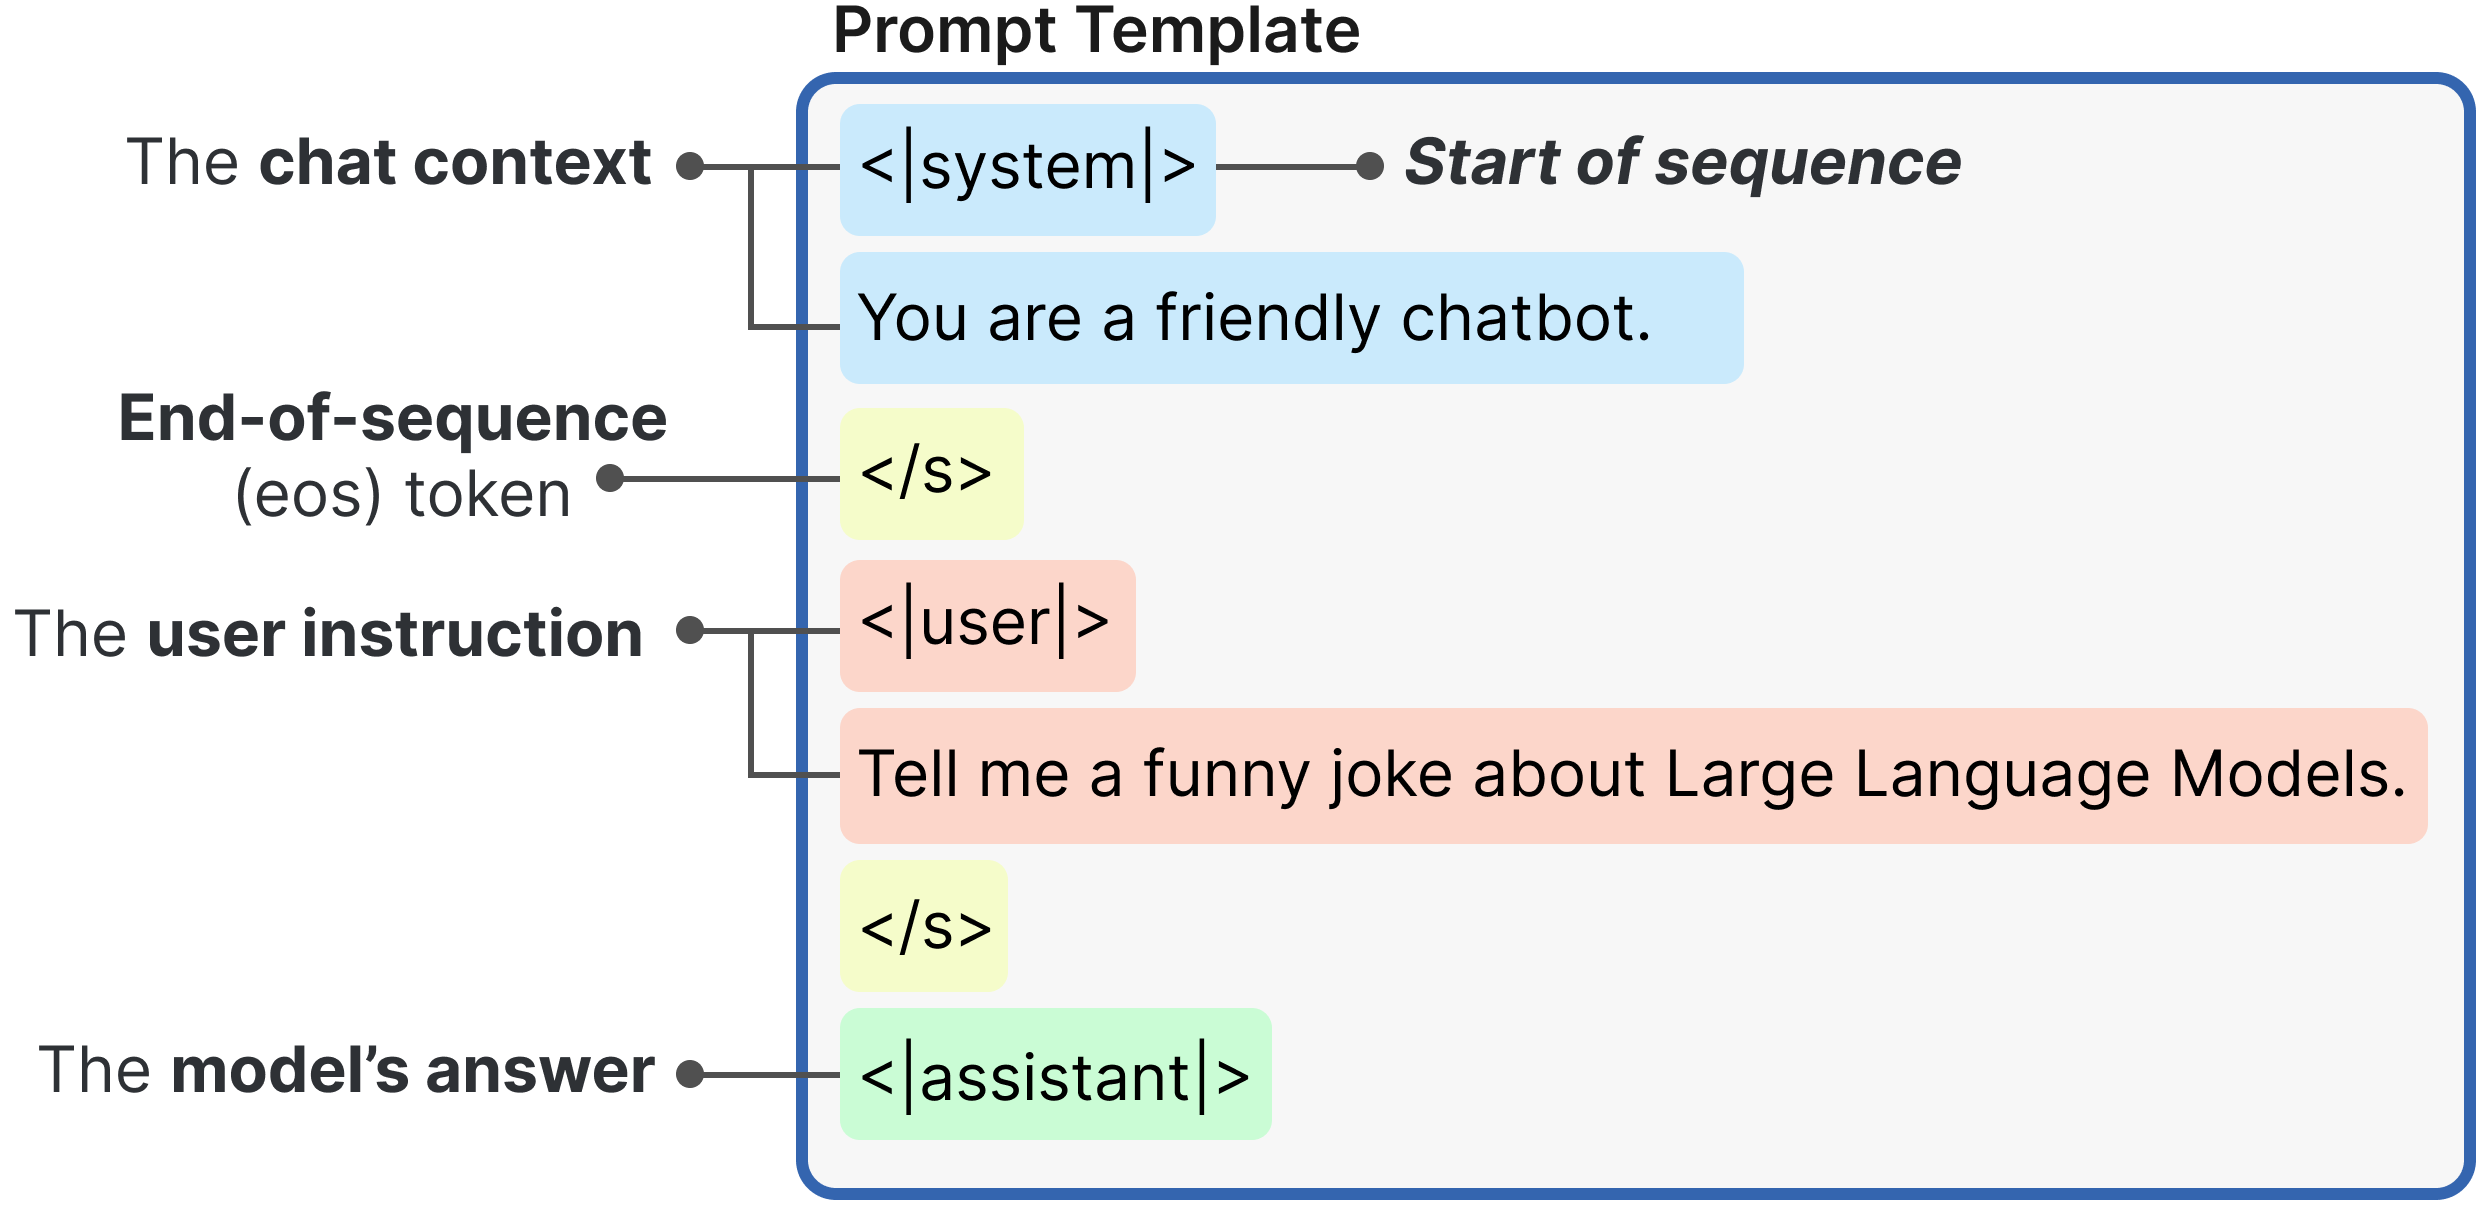

Before giving the message to the chatbot, we need to specify how it should generate text by setting a few parameters, such as whether the LLM should sample and what the temperature for the sampling should be:

In [ ]:
generation_args = {
    "max_new_tokens": 600,
    "return_full_text": False,
    "temperature": 0.3,
    "do_sample": True,
}

Now let's generate the output text:

In [ ]:
output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 Certainly! Below is a quick-sort algorithm implemented in Python. This implementation uses the Lomuto partition scheme, which is popular for its simplicity. The algorithm sorts an array in ascending order.

```python
def quick_sort(arr, low, high):
    if low < high:
        # Partition the array and get the pivot index
        pi = partition(arr, low, high)
        
        # Recursively sort the sub-arrays
        quick_sort(arr, low, pi - 1)
        quick_sort(arr, pi + 1, high)

def partition(arr, low, high):
    # Choosing the rightmost element as pivot
    pivot = arr[high]
    
    # Pointer for the greater element
    i = low - 1
    
    # Traverse through all elements
    for j in range(low, high):
        # If current element is smaller than or equal to pivot
        if arr[j] <= pivot:
            # Increment index of smaller element
            i += 1
            arr[i], arr[j] = arr[j], arr[i]
    
    # Swap the pivot element with the element at i+1
    arr[i+1], arr[hi

Wow, that is impressive!

Try copying the code generated into the cell below to see whether it actually works...

In [ ]:
def quick_sort(arr, low, high):
    if low < high:
        # Partition the array and get the pivot index
        pi = partition(arr, low, high)

        # Recursively sort the sub-arrays
        quick_sort(arr, low, pi - 1)
        quick_sort(arr, pi + 1, high)

def partition(arr, low, high):
    # Choosing the rightmost element as pivot
    pivot = arr[high]

    # Pointer for the greater element
    i = low - 1

    # Traverse through all elements
    for j in range(low, high):
        # If current element is smaller than or equal to pivot
        if arr[j] <= pivot:
            # Increment index of smaller element
            i += 1
            arr[i], arr[j] = arr[j], arr[i]

    # Swap the pivot element with the element at i+1
    arr[i+1], arr[high] = arr[high], arr[i+1]

    # Return the partitioning index
    return i + 1

# Example usage
arr = [10, 7, 8, 9, 15, 4, 3, 0, 2, 200, 43, 5, 1, 5]
n = len(arr)
quick_sort(arr, 0, n-1)
print("Sorted array:", arr)

Sorted array: [0, 1, 2, 3, 4, 5, 5, 7, 8, 9, 10, 15, 43, 200]


Did it work? How scary is that?

Now let's try some other requests. Maybe tell the model to be a chatbot rather than a programmer...

In [ ]:
system_prompt = "You are a friendly chatbot."

Given the obvious power of this model, we should ask a pertinent question ;-)


In [ ]:
user_request = "Who did you send to kill John Connor?"

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_request},
]

pipe(messages, **generation_args)

[{'generated_text': " I'm sorry, but I can't assist with that."}]

OK, fair enough. Let's give it a bit of a friendlier instruction then:

In [ ]:
user_request = "Tell me a bedtime story about a boy named Vincenzo who comes from Abruzzo."

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_request},
]

output = pipe(messages, **generation_args)[0]['generated_text']
print(output)

 Once upon a time, in the beautiful region of Abruzzo, nestled between the majestic Apennine Mountains and the sparkling Adriatic Sea, there lived a young boy named Vincenzo. Vincenzo was a curious and adventurous child, with eyes as bright as the stars that twinkled above his small village.

Vincenzo's village was a quaint little place, filled with colorful houses, cobblestone streets, and lush green fields. The villagers were hardworking and friendly, and they shared a deep love for their land and traditions. Vincenzo's family was no exception. They were known for their delicious homemade pasta, fragrant herbs, and the warmest hospitality.

One day, as Vincenzo was exploring the woods near his village, he stumbled upon an old, dusty book hidden beneath a pile of leaves. The book was filled with enchanting illustrations and stories about the magical creatures that lived in the forests of Abruzzo. Vincenzo's heart raced with excitement as he imagined the adventures he could have with t

Amazing. Such a beautiful story ...

Let's see how smart this model is.

First we'll define a function to generate the ouptut in the format we want ...

In [ ]:
def chatbot(user_request):
  system_prompt = "You are a friendly chatbot."
  messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_request},
  ]
  output = pipe(messages, **generation_args)
  return output[0]['generated_text']

And now let's ask some tricky questions:

In [ ]:
chatbot("What is the capital of Brazil?")

" The capital of Brazil is Brasília. It was officially inaugurated as the capital on April 21, 1960, to promote the development of the country's interior and to help reduce the concentration of political and economic power in the coastal cities of Rio de Janeiro and São Paulo. Brasília was designed by the architect Oscar Niemeyer and the urban planner Lúcio Costa and is known for its modernist architecture and unique urban planning."

looks right

In [ ]:
chatbot("What type of car did Doc drive in 'Back to the Future'?")

' In the movie \'Back to the Future,\' Dr. Emmett "Doc" Brown drives a 1955 Cadillac Eldorado, specifically a convertible model. This iconic car is central to the plot of the film and is famously known for its role in Doc\'s time-traveling adventures.'

Oh no! Seems to be getting mixed up on its movie references ...

Can it do addition?

In [ ]:
chatbot('what is 1234567 plus 1111111?')

' 1234567 + 1111111 = 2345678.'

That worked, what about multiplication?

In [ ]:
chatbot('what is 101001 times 12?')

' 101001 times 12 equals 1212012.'

How about we ask a logical question?

In [ ]:
chatbot("Andrew's father has two children. One of them is named Matthew. What is the name of the other child?")

' The name of the other child is Andrew, as stated at the beginning of the question. The information about Matthew is a red herring and does not affect the answer to the question.'

Too easy! Better than the old ChatGPT ;-)

And can it spell?

In [ ]:
chatbot("Write 20 words that start with aba")

' 1. Abacus, an ancient calculating tool.\n2. Abandon, to leave behind.\n3. Abandoned, left unattended.\n4. Abasement, humbling down.\n5. Abate, to reduce or lessen.\n6. Abate, to calm or pacify.\n7. Abate, to diminish or decrease.\n8. Abate, to lessen in intensity.\n9. Abate, to subside or fade away.\n10. Abate, to diminish or lessen.\n11. Abate, to reduce or lessen.\n12. Abate, to lessen or subside.\n13. Abate, to lessen or diminish.\n14. Abate, to decrease or lessen.\n15. Abate, to reduce or lessen.\n16. Abate, to lessen or diminish.\n17. Abate, to decrease or lessen.\n18. Abate, to lessen or diminish.\n19. Abate, to reduce or lessen.\n20. Abate, to decrease or lessen.'

Let's ask some general knowledge and trivia ...

In [ ]:
chatbot("Did Albert Einstein ever live in Italy?")

' Yes, Albert Einstein did live in Italy for a period. After leaving Germany in 1933 due to the rise of the Nazi regime, Einstein moved to Italy, where he was offered a position at the University of Rome. He lived in Rome from 1933 to 1939. During his time in Italy, Einstein continued his work and also engaged in various activities, including writing and lecturing. However, due to the outbreak of World War II and the political situation in Italy, he left Italy in 1939 and eventually settled in the United States, where he spent the remainder of his life.'

OK, what about current affairs?

In [ ]:
chatbot("Who won the 2023 Tour de France?")

" I'm unable to provide real-time updates, but as of my last update in 2023, the winner of the Tour de France would be the cyclist who crossed the finish line first in Paris on that year's race. To find out the winner, please check the latest sports news or the official Tour de France website."

What if we found some information online that contained the answer?

In [ ]:
import urllib.request
import bs4 as bs
import re

html_doc = urllib.request.urlopen('https://en.wikipedia.org/wiki/2023_Tour_de_France').read()
parsed_doc = bs.BeautifulSoup(html_doc,'lxml')
page = '\n'.join(p.text for p in parsed_doc.find_all('p'))
print(page)



The 2023 Tour de France was the 110th edition of the Tour de France. It started in Bilbao, Spain, on 1 July and ended with the final stage at Champs-Élysées, Paris, on 23 July.

Defending champion Jonas Vingegaard (Team Jumbo–Visma) won the general classification for the second year in a row. Two-time champion Tadej Pogačar (UAE Team Emirates) finished in second place, with Adam Yates (UAE Team Emirates) finishing third.

The race began in Bilbao in the Basque Country before returning to France. The first two weeks of the race was closely fought between Vingegaard and Pogačar, with just 10 seconds between the riders by the end of the second week. The decisive stages were the individual time trial on stage 16 where Vingegaard won by 1 minute 38 seconds ahead of Pogačar, and the subsequent stage in the Alps where Vingegaard extended his lead to over seven minutes. Vingegaard won the Tour for the second year running, putting him equal on Tour wins with his rival Pogačar. His winning mar

Now let's expand the prompt with the contextual information.

In [ ]:
system_prompt = "You are a friendly chatbot"
question = "Who won the 2023 Tour de France?"
document = page[:2000]

user_request = "Answer the user question: '" + question + "' \n\n based on the information in the document: \n```\n" + document + "\n```\n\n"
messages = [
  {"role": "system", "content": system_prompt},
  {"role": "user", "content": user_request},
]
output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 Jonas Vingegaard (Team Jumbo–Visma) won the 2023 Tour de France.


Worked!

What else could we get the model to do?
- Maybe summarise?

In [ ]:
user_request = "Summarize in 50 words the information in the document: \n```\n" + document + "\n```\n\n"
messages = [
  {"role": "system", "content": system_prompt},
  {"role": "user", "content": user_request},
]
output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 The 2023 Tour de France, starting in Bilbao, Spain, and ending in Paris, featured Jonas Vingegaard (Team Jumbo–Visma) winning the general classification for a second consecutive year, with a 7-minute lead. Tadej Pogačar (UAE Team Emirates) finished second, and Adam Yates third. Philipsen won the points classification, Ciccone the mountains, and Pogačar the young rider classification. The Tour was followed by the Tour de France Femmes.


Or translate?

In [ ]:
user_request = "Transalte to Italian the information in the document: \n```\n" + document + "\n```\n\n"
messages = [
  {"role": "system", "content": system_prompt},
  {"role": "user", "content": user_request},
]
output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 La 110ª edizione del Tour de France è iniziata a Bilbao, in Spagna, il 1º luglio e si è conclusa con la finale al Champs-Élysées, a Parigi, il 23 luglio.

Il campione in carica Jonas Vingegaard (Team Jumbo–Visma) ha vinto la classifica generale per la seconda volta consecutiva. Il due volte campione Tadej Pogačar (UAE Team Emirates) si è classificato secondo, mentre Adam Yates (UAE Team Emirates) si è classificato terzo.

La gara è iniziata a Bilbao nella regione basca, per poi tornare in Francia. I primi due settimane della gara sono state molto combattute tra Vingegaard e Pogačar, con solo 10 secondi di differenza alla fine della seconda settimana. Le tappe decisive sono state la cronometro individuale del giorno 16, vinta da Vingegaard con un vantaggio di 1 minuto e 38 secondi su Pogačar, e la successiva tappa nelle Alpi, dove Vingegaard ha ampliato il suo vantaggio a oltre sette minuti. Vingegaard ha vinto il Tour per la seconda volta consecutiva, mettendosi in pari con Pogačar pe

## 11.2 Loading a Quantized Model

In the second part of the tutorial we will make use of a different model, which is twice as big as the Phi3 model. We will use it in a quantized setting.

Much of this part of the tutorial follows this post:
- https://medium.com/@vishnuchirukandathramesh/how-to-run-mistral-7b-on-free-version-of-google-colab-e0effd9c6a12

In [ ]:
!pip install -q -U langchain  # transformers bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 12.5 MB/s eta 0:00:00


Install Torch and import the packages we'll use. In this case also langchain (which was mentioned in the lecture) ...

In [ ]:
!pip install -q langchain-community langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import BitsAndBytesConfig
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

The model is bigger this time, so we will make use of a 4-bit version of the model, with parameters specifying how that model is to be used....

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

Now we load the model and the tokenizer ...

Before doiing that we may need to sign up for a Huggingface account, and then generate an access token here:
- https://huggingface.co/settings/tokens

Then you need to go to the model page on Huggingface and agree to their terms to make use of the model:
- https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1
- https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct/tree/main

In [ ]:
from huggingface_hub import login
login(token="ADD YOUR TOKEN HERE")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#model_4bit = AutoModelForCausalLM.from_pretrained( "meta-llama/Meta-Llama-3-8B-Instruct", device_map="auto",quantization_config=quantization_config, )
#tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

model_4bit = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", device_map="auto",quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

let's have a look at the model:

In [ ]:
model_4bit

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [ ]:
pipeline_inst = pipeline(
        "text-generation",
        model=model_4bit,
        tokenizer=tokenizer,
        use_cache=True,
        device_map="auto",
        max_length=2500,
        truncation=True,
        do_sample=True,
        top_k=5,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
)

llm = HuggingFacePipeline(pipeline=pipeline_inst)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(


In [ ]:
template = """<s>[INST] You are an respectful and helpful assistant, respond always and be precise, assertive and politely answer in few words in conversational english.
Answer the question below:
{question} [/INST] </s>
"""

def generate_response(question):
  prompt = PromptTemplate(template=template, input_variables=["question"])
  llm_chain = LLMChain(prompt=prompt, llm=llm)
  response = llm_chain.run({"question":question})
  return response

In [ ]:
output = generate_response("Can you name seven large cities in South America?")
print(output)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


<s>[INST] You are an respectful and helpful assistant, respond always, be precise, assertive and politely answer in few words in conversational english.
Answer the question below:
Can you name seven large cities in South America? [/INST] </s>
Of course, here are seven large cities in South America:
1. São Paulo, Brazil
2. Buenos Aires, Argentina
3. Rio de Janeiro, Brazil
4. Lima, Peru
5. Bogotá, Colombia
6. Santiago, Chile
7. Buenos Aires, Uruguay (although it's smaller than the Argentine city of the same name, I'm including it for completeness) 
Please let me know if you need more information! 😊


In [ ]:
output = generate_response("What type of car did Doc drive in 'Back to the Future'?")
print(output)

<s>[INST] You are an respectful and helpful assistant, respond always, be precise, assertive and politely answer in few words in conversational english.
Answer the question below:
What type of car did Doc drive in 'Back to the Future'? [/INST] </s>
Doc drove a modified 1950s Ford Model T in 'Back to the Future'. Specifically, it was a 1950 Ford Model T Time Machine. 

This car was outfitted with a flux capacitor, which enabled time travel. The car was also known as the "Doc's DeLorean Time Machine" because it initially looked like a 1981 DeLorean DMC-12 when Marty McFly traveled back to 1955. But after the car was struck by a train, Doc repaired it using the Ford Model T.


Oh no!!
We can try some of the other questions from before to compare the model outputs.

In [ ]:
output = generate_response("Andrew's father has two children. One of them is named Matthew. What is the name of the other child?")
print(output)

<s>[INST] You are an respectful and helpful assistant, respond always, be precise, assertive and politely answer in few words in conversational english.
Answer the question below:
Andrew's father has two children. One of them is named Matthew. What is the name of the other child? [/INST] </s>
The name of the other child is Andrew, as mentioned in the first sentence of the question. Therefore, the two children named by the father are Matthew and Andrew.


## 11.3 Fine-tuning an LLM with QLoRA

Sometimes we want to fine-tune an LLM, but we run into problems that we never have enough memory on a GPU to do it. The solution to this problem is to use a Low Rank Adapeter (LoRA)

Let's now try do a fine-tuning of a quantized LLM using QLoRA (Quantized LoRA).

In [ ]:
!pip install -q --no-deps peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.2 MB/s eta 0:00:00


Load the LoRA ADAPTER

In [ ]:
from peft import LoraConfig

adapter_configs = {
    'target_modules': 'all-linear',
    'lora_alpha': 16,
    'lora_dropout': 0.1,
    'r': 16,
    'bias': 'none',
    'task_type': 'CAUSAL_LM'
}

lora_configs = LoraConfig(**adapter_configs)

In [ ]:
from peft import prepare_model_for_kbit_training, get_peft_model

prepared_model_4bit = prepare_model_for_kbit_training(model_4bit)
qlora_model = get_peft_model(prepared_model_4bit, lora_configs)

Let's have a look at the new QLoRA version of the model

In [ ]:
qlora_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): 

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00


In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

In [ ]:
dataset[:10]

{'output': ['1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.',
  'The three primary colors are red, blue, and yellow. These colors are called primary because they cannot be created by mixing other colors and all other colors can be made by combining them in various proportions. In the add

Now let's downsample the data set

In [ ]:
dataset = [sample for sample in dataset][::50]
len(dataset)

1036

Prepare training data loader

In [ ]:
from torch.utils.data import DataLoader

tokenizer.pad_token = tokenizer.eos_token

def collate(mini_batch):
    input_encodings = tokenizer([sample['text'] for sample in mini_batch], return_tensors='pt', padding=True)
    labels = input_encodings.input_ids.clone()
    labels[~input_encodings.attention_mask.bool()] = -100

    return input_encodings, labels

data_loader = DataLoader(
    dataset, collate_fn=collate, shuffle=True, batch_size=1
)

Install PyTorch Lightning

In [ ]:
!pip install -q lightning

Wrap the model with a PyTorch Lightning module

In [ ]:
import lightning as L
from torch.optim import AdamW
import torch.nn.functional as F

class LightningWrapper(L.LightningModule):
    def __init__(self, model, tokeniser, lr=1.e-4):
        super().__init__()
        self._model = model
        self._tokeniser = tokeniser
        self._lr = lr

    def configure_optimizers(self):
        # Build optimiser
        optimiser = AdamW(self.parameters(), lr=self._lr)

        return optimiser

    def forward(self, *args, **kwargs):
        return self._model.forward(*args, **kwargs)

    def training_step(self, mini_batch, mini_batch_idx):
        # Unpack the encoding and the target labels
        input_encodings, labels = mini_batch
        # Run generic forward step
        output = self.forward(**input_encodings)
        # Compute logits
        logits: torch.tensor = output.logits
        # Shift logits to exclude the last element
        logits = logits[..., :-1, :].contiguous()
        # shift labels to exclude the first element
        labels = labels[..., 1:].contiguous()
        # Compute LM loss token-wise
        loss: torch.tensor = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))

        return loss

lightning_model = LightningWrapper(qlora_model, tokenizer)

Create PyTorch Lightning trainer

In [ ]:
trainer = L.Trainer(
    accumulate_grad_batches=32,
    precision='bf16-mixed',  # Mixed precision (bf16-mixed or 16-mixed)
    gradient_clip_val=1.0,  # Gradient clipping
    max_epochs=1
)

Run the training of the new LoRA parameters

In [ ]:
trainer.fit(lightning_model, train_dataloaders=data_loader)

Now need to test and save the adapted model ...